# Automatic Fit of Transit Ligthcurve

In this notebook you will see how to use batman and transitfit packages to fit your transit lightcurve. 

Currently, the transitfit package crash during saving the results. But, you'll have access to the best parameters it finds. An [issue](https://github.com/joshjchayes/TransitFit/issues/10) is open on the github of the library. 

First, you need to install the requirements. Simply, run the two next lines and everything gonna be ok. 

In [3]:
!pip install --upgrade transitfit


     |████████████████████████████████| 308 kB 4.6 MB/s eta 0:00:01
  Attempting uninstall: transitfit
    Found existing installation: transitfit 2.2.5
    Uninstalling transitfit-2.2.5:
      Successfully uninstalled transitfit-2.2.5


In [2]:
!pip install tqdm

     |████████████████████████████████| 75 kB 1.2 MB/s eta 0:00:01


In [1]:
# import the packages 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
mpl.style.use('seaborn')
from scipy.io import netcdf



In [2]:
import transitfit
transitfit.__version__

'2.3.0'

In [2]:
# import data for visualization
data = np.loadtxt( '55Cance.dat' )

    

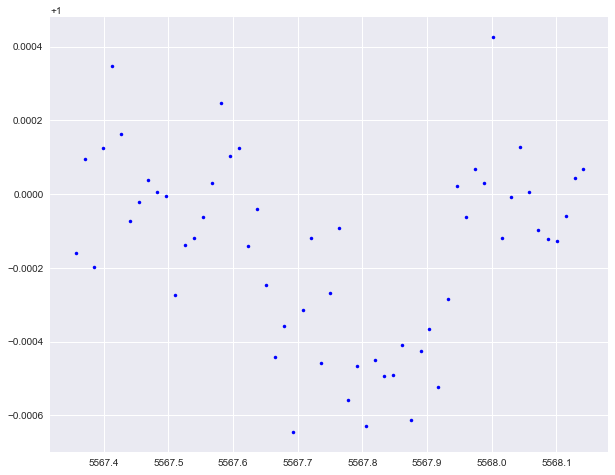

In [3]:
# visu 
plt.figure(figsize=(10,8))
plt.plot(data[:, 0], data[:, 1], 'b.')



You can add an error on each point corresponding to a fix 0.00015

In [4]:
err = [list(i) for i in data]
for i in err:
    i.append(0.00015)
# save the new file in txt, transitfit doesn't accept the .dat format
np.savetxt('55Cance.txt',err) 

## JP - Code

Now, the code of the Jedi Master. 

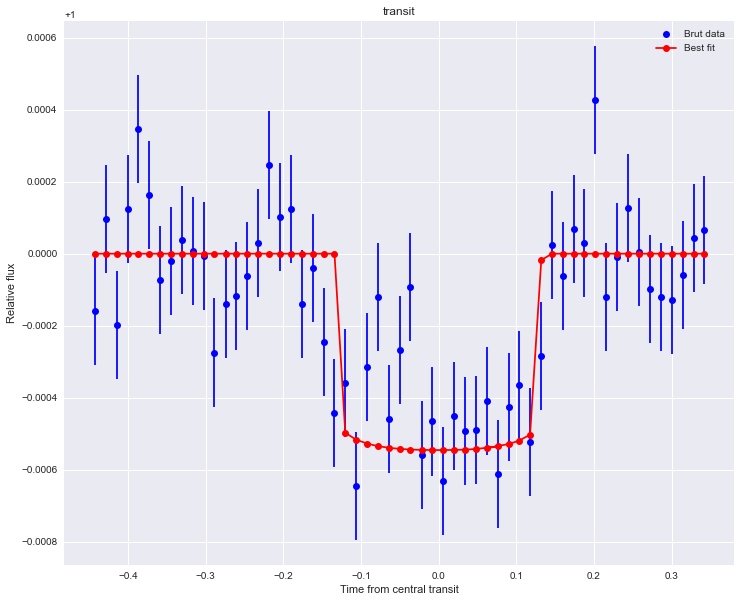

In [9]:
# working with batman-package and numpy == 1.8.0
import batman
import numpy as np
import matplotlib.pyplot as plt
file='55Cance.dat'
data = np.loadtxt(file)
t_data = data[:,0]-5567.8
flux_data = data[:,1]
err_data = flux_data-flux_data+0.00015
Np_data = t_data.size
params = batman.TransitParams()
params.t0 = 0.0 #time of inferior conjunction
params.per = 0.7 #orbital period
params.rp = 0.023 #planet radius (in units of stellar radii)
params.a = 1.1 #semi-major axis (in units of stellar radii)
params.inc = 90 #orbital inclination (in degrees)
params.ecc = 0. #eccentricity
params.w = 90. #longitude of periastron (in degrees)
params.u = [0.038,0.101] #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic" #limb darkening model
mod = batman.TransitModel(params, t_data) #calculating model for all tp values
flux_mod = mod.light_curve(params) #calculating model for all tp values
plt.figure(figsize=(12,10))
plt.plot(t_data,flux_data, 'bo', label='Brut data')
plt.errorbar(t_data,flux_data,yerr=err_data,capsize=5,ecolor='blue',fmt = 'none')
plt.plot(t_data, flux_mod,'ro-', label='Best fit')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.title("transit")
plt.legend() # legend text comes from the plot's label parameter.
plt.grid(True)
plt.show()

Great, at this step, you know how to use batman and the different parameters to play with. Now, we will use a library call [TransitFit](https://arxiv.org/abs/2103.12139) to tune the parameters and the limbdarkening autonomously. The documentation of the library can be found [here](https://transitfit.readthedocs.io/en/latest/). 

## Transitfit

The first step is to create the different files needed to use transitfit. 
For that you need to create 3 files (2 needed, 1 optional). The input, the priors and the filter profiles. With these three files you can specify every telescope you have, the different filters, the wavelength etc etc... 

### Input file

In [2]:
PATH = '55Cance.txt'

In [3]:
columns = ['Path', 'Telescope', 'Filter', 'Epoch', 'Detrending']

In [4]:
data = []
data.append([PATH, 0, 0, 0, 0])
#data.append([PATH, 1, 0, 0, 0])


In [5]:
df = pd.DataFrame(data=data)
df.columns = columns

In [6]:
# input data
df.to_csv('input_data.csv', sep=',', index=False)



Then, we need to create the priors file. This file contains the parameters of the system.

### Priors file

In [7]:
params = []

In [8]:
params.append(['P', 'gaussian', 0.7, 0.001, 0])
params.append(['t0', 'gaussian', 0., 0.007, 0])
params.append(['a', 'gaussian', 1.1, 0.5, 0])
params.append(['inc', 'gaussian', 90, 1.2, 0])
params.append(['ecc', 'fixed', 0., 0,0])
params.append(['w', 'gaussian', 90, 1.2, 0])
params.append(['rp', 'uniform', 0.023, 0.03, 0])
params.append(['q0', 'gaussian', 0.038, 0.04, 0])
params.append(['q0', 'gaussian', 0.101, 0.12, 0])

In [9]:
params

[['P', 'gaussian', 0.7, 0.001, 0],
 ['t0', 'gaussian', 0.0, 0.007, 0],
 ['a', 'gaussian', 1.1, 0.5, 0],
 ['inc', 'gaussian', 90, 1.2, 0],
 ['ecc', 'fixed', 0.0, 0, 0],
 ['w', 'gaussian', 90, 1.2, 0],
 ['rp', 'uniform', 0.023, 0.03, 0],
 ['q0', 'gaussian', 0.038, 0.04, 0],
 ['q0', 'gaussian', 0.101, 0.12, 0]]

In [10]:
df_params = pd.DataFrame(data=params)
df_params.columns = ['Parameters', 'Distribution', 'InputA', 'InputB', 'Filter']

In [11]:
df_params.to_csv('priors.csv', sep=',', index=False)

### Filter profiles file

In [12]:
df_filter = pd.DataFrame(data=[[0, 'R',0]])#.T

df_filter.columns=['Filter', 'InputA', 'InputB']

In [13]:
df_filter.to_csv('filter_profiles.csv', sep=',', index=False)

## Fit the parameters 

In [3]:
from transitfit import run_retrieval

The function works autonomously but you need to create 2 folders: fitted_lightcurves and output_parameters. The function doesn't create them for you and will crash... Trust me... 

In [4]:
results = run_retrieval('input_data.csv', 'priors.csv', 'filter_profiles.csv', plot=True)#, fitting_mode='batched')

0it [00:00, ?it/s]

Auto mode detect has set 'all' mode
Priors:
Limb darkening model: quadratic
n telescopes: 1
n filters: 1
n epochs: 1
P:	t -	f -	e -	Gaussian - mean: 0.7 - stdev: 0.001
t0:	t -	f -	e -	Gaussian - mean: 0.0 - stdev: 0.007
a:	t -	f -	e -	Gaussian - mean: 1.1 - stdev: 0.5
rp:	t -	f 0	e -	Uniform - min: 0.023 - max: 0.03
inc:	t -	f -	e -	Gaussian - mean: 90.0 - stdev: 1.2
ecc:	t -	f -	e -	Fixed - value: 0.0
w:	t -	f -	e -	Gaussian - mean: 90.0 - stdev: 1.2
q0:	t -	f 0	e -	Uniform - min: 0 - max: 1
q1:	t -	f 0	e -	Uniform - min: 0 - max: 1
norm:	t 0	f 0	e 0	Uniform - min: 0.4997867363811523 - max: 1.500967929709325
d0_0:	t 0	f 0	e 0	Uniform - min: -10 - max: 10
Total 12 fitting parameters


11195it [04:04, 45.83it/s, +300 | bound: 124 | nc: 1 | ncall: 641913 | eff(%):  1.791 | loglstar:   -inf < -55.636 <    inf | logz: -91.791 +/-  0.478 | dlogz:  0.001 >  0.309]    



Best fit results:
P:		 0.699998 ± 2.4e-05
t0:		 0.00634 ± 0.00276
a:		 1.045979 ± 0.009489
inc:		 89.028649 ± 0.38642
w:		 89.056769 ± 0.503402
rp_0:		 0.023095 ± 0.000184
q0_0:		 0.5828814001558493 ± 0.1253724485732119
q0_0:		 0.41356767676069567 ± 0.13466627787757873
q0_0:		 0.00656247818280044 ± 0.08163999511943787
q1_0:		 0.5889636777052556 ± 0.15408806439596243
d0_0:		 -2.6e-05 ± 5.7e-05
norm_t0_f0_e0:	 0.999961 ± 1.5e-05
chi2:		 55.63576
red chi2:	 0.9935
Saving full results...
Extracting results dict
Plotting batch 0 samples to ./plots/unfolded/batch_0_samples.png


Calculating best values for this run
Combining results dicts
Exception raised whilst saving results:
index 1 is out of bounds for axis 0 with size 1
Unable to save results
Initialising best fit model


  File "/Users/gen06846/anaconda3/envs/QML/lib/python3.9/site-packages/transitfit/retriever.py", line 360, in _run_full_retrieval
    output_handler.save_results([results], [priors], [lightcurves],
  File "/Users/gen06846/anaconda3/envs/QML/lib/python3.9/site-packages/transitfit/output_handler.py", line 332, in save_results
    best_vals, combined_results = self.get_best_vals(results_dicts, fit_ld)
  File "/Users/gen06846/anaconda3/envs/QML/lib/python3.9/site-packages/transitfit/output_handler.py", line 446, in get_best_vals
    best_vals, combined_dict = self.add_best_u(best_vals, combined_dict)
  File "/Users/gen06846/anaconda3/envs/QML/lib/python3.9/site-packages/transitfit/output_handler.py", line 535, in add_best_u
    filter_q[b,0,qi] = combined_dict[q][i][b][0]


FileNotFoundError: [Errno 2] No such file or directory: './output_parameters/summary_output.csv'

In [ ]:
# A complete list of the parameters can be seen here
run_retrieval??

In [ ]:
#results = run_retrieval('input_data.csv', 'priors.csv', 'filter_profiles.csv', fitting_mode='all',plot=True, results_output_folder='summary', summary_file='test.csv',final_lightcurve_folder='lightcurve')

In [5]:
import transitfit
transitfit.__version__

'2.3.0'